In [1]:
# packages

from collections import defaultdict, OrderedDict, Counter
from datetime import datetime

from dateutil.relativedelta import relativedelta
import glob
from itertools import product, combinations
import matplotlib.pyplot as plt
import numpy    as np
#import networkx as nx
from operator import itemgetter
import pandas   as pd
import rdflib as rdflib
import re
from scipy.signal import convolve2d
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer, minmax_scale
from SPARQLWrapper import SPARQLWrapper, JSON, POST, TURTLE
import sys
from rdflib.namespace import XSD, Namespace
from rdflib.term import URIRef

import IPython
import pprint
pp = pprint.PrettyPrinter(indent=4)



from constants import *
from helpers import *

In [2]:
# helpers

# tuples
end_year=2022
start_year=1971
period_length=5
year_range = end_year - start_year
modulo = year_range % period_length
if modulo == 0:
    final_start = end_year - period_length
else:
    final_start = end_year - modulo
final_end = end_year + 1

starts = np.arange(start_year, final_start, period_length).tolist()
tuples = [(start, start+period_length) for start in starts]# five year periods
# make 5-year bins


# We'll add the last period calculated earlier
tuples.append(tuple([final_start, final_end]))
bins = pd.IntervalIndex.from_tuples(tuples, closed='left')
original_labels = list(bins.astype(str))
new_labels = ['{} - {}'.format(b.strip('[)').split(', ')[0], int(b.strip('[)').split(', ')[1])-1) for b in original_labels]
label_dict = dict(zip(original_labels, new_labels))

# add period function
def add_period(df_fo, columnname="year"):
    df_fo['period'] = pd.cut(df_fo[columnname], bins=bins, include_lowest=True, precision=0)
    df_fo['period'] = df_fo['period'].astype("str")

    df_fo["period"]=df_fo["period"].apply(lambda x: int(x.split(",")[0].replace("[","")))
    return df_fo

# decade function
def add_decade(df_fi, columname="year"):
    df_fi["decade"]=(df_fi["year"]-1)- ((df_fi["year"]-1)%10)
    
    return df_fi

In [55]:
df_fi=pd.read_csv("../../data/df_fi_all.csv", sep="\t", index_col=0)
df_fo=pd.read_csv("../../data/df_fo_all2.csv", sep="\t", index_col=0)

In [56]:
fi_pub=df_fi.dropna(subset="publisher")


fi_pub[["publisher","pubName"]].nunique() # as many names as 

publisher    777
pubName      777
dtype: int64

In [57]:
print(fi_pub[fi_pub["pubName"].str.contains("Karjala")]["pubName"].unique())


['Karjala' 'Karjala-kustantamo' 'Karjalan kirjapaino'
 'Karjalan sivistyseura']


In [58]:
fi_pub["lang"]="http://lexvo.org/id/iso639-3/fin"

/tmp/ipykernel_5804/2961609278.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fi_pub["lang"]="http://lexvo.org/id/iso639-3/fin"


In [59]:
fo_pub=df_fo.dropna(subset="publisher")
print(fo_pub[fo_pub["pubName"].str.contains("Karjala")]["pubName"].unique())

# replace "Karjala" with "Karjala-Kustantamo"

fo_pub[["publisher","pubName"]].nunique() # as many names as 

['Karjala']


publisher    323
pubName      323
dtype: int64

In [60]:
fo_pub.groupby("lang")["novel"].nunique().sort_values()

lang
http://lexvo.org/id/iso639-3/glg        1
http://lexvo.org/id/iso639-3/lat        1
http://lexvo.org/id/iso639-3/kik        1
http://lexvo.org/id/iso639-5/fiu        1
http://lexvo.org/id/iso639-3/hrv        1
http://lexvo.org/id/iso639-3/hin        1
http://lexvo.org/id/iso639-3/lit        1
http://lexvo.org/id/iso639-3/fit        1
http://lexvo.org/id/iso639-3/vec        1
http://lexvo.org/id/iso639-3/mkd        1
http://lexvo.org/id/iso639-3/chm        1
http://lexvo.org/id/iso639-5/bnt        1
http://lexvo.org/id/iso639-3/bel        1
http://lexvo.org/id/iso639-3/ben        1
http://lexvo.org/id/iso639-3/vie        1
http://lexvo.org/id/iso639-3/bos        1
http://lexvo.org/id/iso639-3/ind        2
http://lexvo.org/id/iso639-3/slk        2
http://lexvo.org/id/iso639-3/hye        2
http://lexvo.org/id/iso639-3/ukr        3
http://lexvo.org/id/iso639-3/kat        3
http://lexvo.org/id/iso639-3/grc        3
http://lexvo.org/id/iso639-3/srp        3
http://lexvo.org/id/iso639-3/

In [78]:
#  top x

top_fi=df_fi.groupby(["pubName","publisher"])["novel"].nunique().sort_values(ascending=False).head(10).reset_index()
top_fi

,pubName,publisher,novel
0,WSOY,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,1946
1,Otava,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,1810
2,Tammi,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,1550
3,Eget förlag,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,1039
4,Karisto Oy,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,984
5,BoD - Books on Demand,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,935
6,Gummerus,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,771
7,Myllylahti,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,461
8,Mediapinta Oy,http://www.seco.tkk.fi/applications/saha#Insta...,313
9,Kustannus-Mäkelä,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,273


In [82]:
omakustantajat=list(top_fi[top_fi["pubName"].isin(["Eget förlag","BoD - Books on Demand", "Mediapinta Oy"])]["publisher"])

In [88]:
#all_pubs[all_pubs["pubName"].str.contains("Bookcover")]

In [64]:
all_pubs=pd.concat([fi_pub, fo_pub])
all_pubs.sort_values(by="year")

,year,author,nat,gender,novel,publisher,pubName,genre,year_genre,decade,lang
60,1971,http://www.yso.fi/onto/kaunokki#person_1231760...,http://www.yso.fi/onto/koko/p73101,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/kaunokki#ateos_10280,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kustannusosakeyhtiö Otava,NaN,NaN,NaN,http://lexvo.org/id/iso639-3/eng
10007,1971,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#female,http://www.yso.fi/onto/kaunokki#ateos_19267,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Weilin + Göös,jannitys,1971.0,1970.0,http://lexvo.org/id/iso639-3/fin
142,1971,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p2224,http://www.yso.fi/onto/kaunokki#female,http://www.yso.fi/onto/kaunokki#ateos_4288,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kustannusosakeyhtiö Tammi,jannitys,NaN,1970.0,http://lexvo.org/id/iso639-3/eng
141,1971,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p2224,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/kaunokki#ateos_3996,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,WSOY,jannitys,NaN,1970.0,http://lexvo.org/id/iso639-3/eng
140,1971,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p73101,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/kaunokki#ateos_8820,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kustannusosakeyhtiö Tammi,jannitys,NaN,1970.0,http://lexvo.org/id/iso639-3/eng
...,...,...,...,...,...,...,...,...,...,...,...
5969,2020,http://data.kirjasampo.fi/actor_Luik%2C+Rolf,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://data.kirjasampo.fi/abstractWork_7114472,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,BoD - Books on Demand,huumori,2020.0,2010.0,http://lexvo.org/id/iso639-3/fin
5971,2020,http://data.kirjasampo.fi/actor_Kivel%C3%A4%2C...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#female,http://data.kirjasampo.fi/abstractWork_7128521,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,BoD - Books on Demand,NaN,NaN,NaN,http://lexvo.org/id/iso639-3/fin
6012,2020,http://seco.tkk.fi/saha3/uf6c4db79-57f6-49a5-b...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#female,http://data.kirjasampo.fi/abstractWork_7055985,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,WSOY,NaN,NaN,NaN,http://lexvo.org/id/iso639-3/fin
5768,2020,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://data.kirjasampo.fi/abstractWork_7085099,http://data.kirjasampo.fi/actor_Aviador,Aviador,NaN,NaN,NaN,http://lexvo.org/id/iso639-3/fin


In [90]:
# filter out all < 30 novels
verysmall= all_pubs.groupby("publisher")["novel"].nunique().reset_index()#<30
smalls=verysmall[verysmall["novel"]<30]
# filter out books on demand, mediapinta, omakustanne
not_wanted= list(smalls["publisher"]) + omakustantajat
real_pubs=all_pubs[~all_pubs["publisher"].isin(not_wanted)]
real_pubs



,year,author,nat,gender,novel,publisher,pubName,genre,year_genre,decade,lang
2,1972,http://seco.tkk.fi/saha3/uc84440c2-42e7-4ba7-b...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#female,http://www.yso.fi/onto/kaunokki#ateos_20145,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Weilin + Göös,NaN,NaN,NaN,http://lexvo.org/id/iso639-3/fin
4,2017,http://www.btj.fi/actor_Matilainen%2C+Pekka,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://data.kirjasampo.fi/abstractWork_4409323,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Atena Kustannus Oy,jannitys,2017.0,2010.0,http://lexvo.org/id/iso639-3/fin
5,1982,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/kaunokki#ateos_44817,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,WSOY,jannitys,1982.0,1980.0,http://lexvo.org/id/iso639-3/fin
6,2006,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#female,http://seco.tkk.fi/saha3/u04ea928f-31f2-4ebd-a...,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Tammi,NaN,NaN,NaN,http://lexvo.org/id/iso639-3/fin
7,1984,http://seco.tkk.fi/saha3/u9d2d1008-80a8-4f00-9...,http://www.yso.fi/onto/koko/p35259,unk,http://seco.tkk.fi/saha3/u6332bb33-146f-499b-a...,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Tammi,jannitys,1984.0,1980.0,http://lexvo.org/id/iso639-3/fin
...,...,...,...,...,...,...,...,...,...,...,...
19395,2020,http://data.kirjasampo.fi/actor_Ahnhem%2C+Stefan,http://www.yso.fi/onto/koko/p16897,http://www.yso.fi/onto/kaunokki#male,http://data.kirjasampo.fi/abstractWork_7029250,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,WSOY,jannitys,NaN,2010.0,http://lexvo.org/id/iso639-3/swe
19397,2020,http://www.yso.fi/onto/kaunokki#person_1231760...,http://www.yso.fi/onto/koko/p2224,http://www.yso.fi/onto/kaunokki#female,http://data.kirjasampo.fi/abstractWork_4435226,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Karisto Oy,jannitys,NaN,2010.0,http://lexvo.org/id/iso639-3/eng
19398,2020,http://data.kirjasampo.fi/actor_Sehlstedt%2C+K...,http://www.yso.fi/onto/koko/p16897,http://www.yso.fi/onto/kaunokki#female,http://data.kirjasampo.fi/abstractWork_6986740,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Like,jannitys,NaN,2010.0,http://lexvo.org/id/iso639-3/swe
19399,2020,http://data.kirjasampo.fi/actor_Harris%2C+Neil...,http://www.yso.fi/onto/koko/p73101,http://www.yso.fi/onto/kaunokki#male,http://data.kirjasampo.fi/abstractWork_7094878,http://data.kirjasampo.fi/actor_Aula+%26+Co,Kustannusosakeyhtiö Aula & Co,NaN,NaN,NaN,http://lexvo.org/id/iso639-3/eng


In [125]:
# get min year, max year, nr of publications
pub_profiles=pd.DataFrame()

pub_profiles["min"]=real_pubs.groupby("publisher")["year"].min().values
pub_profiles["max"]=real_pubs.groupby("publisher")["year"].max().values
pub_profiles["novels"]=real_pubs.groupby("publisher")["novel"].nunique().values
pub_profiles["authors"]=real_pubs.groupby("publisher")["author"].nunique().values
fi_count=real_pubs[real_pubs["lang"]=="http://lexvo.org/id/iso639-3/fin"].groupby("publisher")["novel"].nunique().reset_index()
pub_profiles["publisher"]=real_pubs.groupby("publisher")["year"].min().index
pub_profiles["pubName"]=real_pubs.groupby("publisher")["pubName"].unique().values

pub_profiles=pub_profiles.merge(fi_count, how="left")
pub_profiles["novel_fi"]=pub_profiles["novel"].fillna(0)

In [101]:
pub_profiles

,min,max,novels,authors,publisher,novel,novel_fi
0,2018,2020,66,48,http://data.kirjasampo.fi/actor_Atrain+%26+Nord,61.0,61.0
1,2016,2020,63,40,http://data.kirjasampo.fi/actor_Aula+%26+Co,16.0,16.0
2,2015,2020,54,43,http://data.kirjasampo.fi/actor_Aviador,27.0,27.0
3,2015,2020,293,152,http://data.kirjasampo.fi/actor_HarperCollins+...,NaN,0.0
4,2016,2020,82,51,http://data.kirjasampo.fi/actor_S%26S,26.0,26.0
...,...,...,...,...,...,...,...
76,1997,2020,44,27,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,8.0,8.0
77,1974,2020,92,37,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,44.0,44.0
78,1986,2017,192,110,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,NaN,0.0
79,1987,2020,56,32,http://www.yso.fi/onto/kaunokki#Kustantaja_146...,56.0,56.0


In [126]:
pub_profiles["age"]=pub_profiles["max"]-pub_profiles["min"]

In [127]:
pub_profiles["finnishness"]=pub_profiles["novel_fi"]/pub_profiles["novels"]

In [185]:
pub_profiles["oldness"]=2020-pub_profiles["min"]#-pub_profiles["min"]

In [205]:
pub_profiles.rename({"age":"ikä","finnishness":"suom. osuus"},axis=1)

,min,max,novels,authors,publisher,pubName,novel,novel_fi,ikä,suom. osuus,oldness
0,2018,2020,66,48,http://data.kirjasampo.fi/actor_Atrain+%26+Nord,"[Atrain & Nord, Atrain&Nord]",61.0,61.0,2,0.924242,2
1,2016,2020,63,40,http://data.kirjasampo.fi/actor_Aula+%26+Co,"[Aula & Co, Kustannusosakeyhtiö Aula & Co]",16.0,16.0,4,0.253968,4
2,2015,2020,54,43,http://data.kirjasampo.fi/actor_Aviador,"[Aviador, Aviador Kustannus]",27.0,27.0,5,0.500000,5
3,2015,2020,293,152,http://data.kirjasampo.fi/actor_HarperCollins+...,[HarperCollins Nordic AB],NaN,0.0,5,0.000000,5
4,2016,2020,82,51,http://data.kirjasampo.fi/actor_S%26S,"[S&S, Kustantamo S&S]",26.0,26.0,4,0.317073,4
...,...,...,...,...,...,...,...,...,...,...,...
76,1997,2020,44,27,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,[Nemo],8.0,8.0,23,0.181818,23
77,1974,2020,92,37,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,[Aikamedia],44.0,44.0,46,0.478261,46
78,1986,2017,192,110,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,[Harlequin],NaN,0.0,31,0.000000,34
79,1987,2020,56,32,http://www.yso.fi/onto/kaunokki#Kustantaja_146...,[Suomen Rauhanyhdistysten Keskusyhdistys ry],56.0,56.0,33,1.000000,33


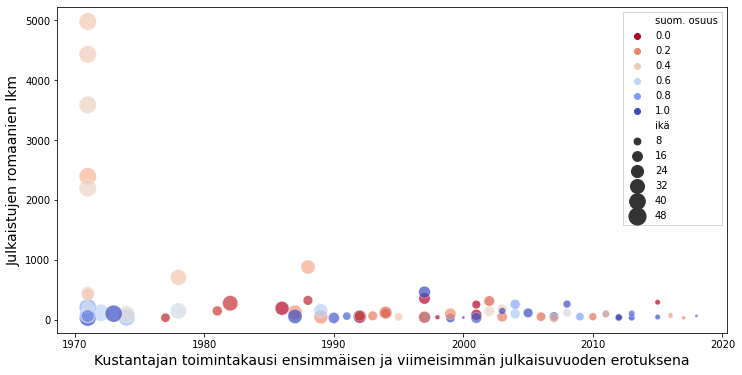

In [209]:
fig, ax= plt.subplots(1,1,figsize=(12,6))


ax=sns.scatterplot(y="novels",x= "min",ax=ax, hue="suom. osuus", data=pub_profiles.rename({"age":"ikä","finnishness":"suom. osuus"},axis=1), 
                   palette=sns.color_palette("coolwarm_r", as_cmap=True),
                  s=60, alpha=0.7, 
                   size="ikä", sizes=(10,300)
                  )#, width=0.8)
plt.legend(loc='best', 
           #bbox_to_anchor=(1.12, 0.5), 
         #  title="suom. osuus",
          ncol=1, fancybox=False, shadow=False)
#plt.margins(0,0)
#plt.yticks([0, 10, 100, 1000, 4000])
plt.xlabel("Kustantajan toimintakausi ensimmäisen ja viimeisimmän julkaisuvuoden erotuksena", fontsize=14)
plt.ylabel("Julkaistujen romaanien lkm", fontsize=14)
ax.xaxis.set_tick_params(rotation=0)

coordinates = [('WSOY',46.1,4950), ('Otava',46,4410), ('Tammi',45.7,3560), ("Gummerus",44.1,2380), ("Karisto",45.6,2150),
               ("Kustannus-Mäkelä",34.2,710), ("Like", 30, 890)]
for x in coordinates: plt.annotate(x[0], (x[1], x[2] ))

In [282]:
from matplotlib import collections as matcoll

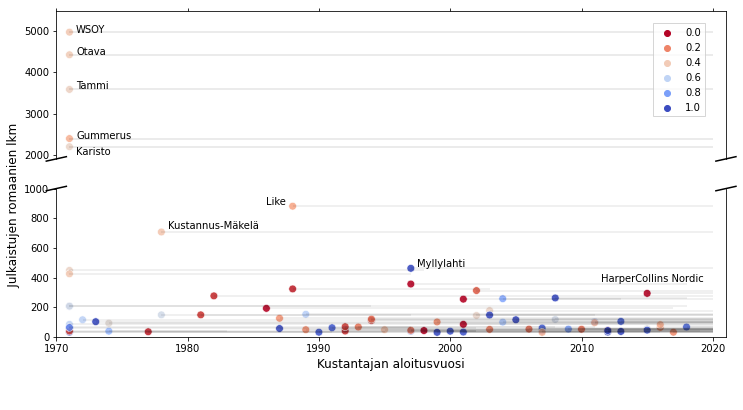

In [343]:
import matplotlib.pyplot as plt
import numpy as np


# 30 points between [0, 0.2) originally made using np.random.rand(30)*.2
pts = np.array([
    0.015, 0.166, 0.133, 0.159, 0.041, 0.024, 0.195, 0.039, 0.161, 0.018,
    0.143, 0.056, 0.125, 0.096, 0.094, 0.051, 0.043, 0.021, 0.138, 0.075,
    0.109, 0.195, 0.050, 0.074, 0.079, 0.155, 0.020, 0.010, 0.061, 0.008])

# Now let's make two outlier points which are far away from everything.
pts[[3, 14]] += .8

# If we were to simply plot pts, we'd lose most of the interesting
# details due to the outliers. So let's 'break' or 'cut-out' the y-axis
# into two portions - use the top (ax) for the outliers, and the bottom
# (ax2) for the details of the majority of our data
fig, (ax, ax2) = plt.subplots(2, 1, sharex=True,figsize=(12,6))

# plot the same data on both axes
#ax.plot(pts)
#ax2.plot(pts)

lines=[]
lines2=[]
for start,end,novels in zip(pub_profiles["min"],pub_profiles["max"],pub_profiles["novels"]):
    #ax2.plot([start,novels],[end,novels],'b-', linewidth=2,color="red")
    if novels > 900:
        lines.append([[start,novels],[end,novels]])
    else:
        lines2.append([[start,novels],[end,novels]])

    
linecoll = matcoll.LineCollection(lines, colors='k',alpha=0.1)
linecoll2 = matcoll.LineCollection(lines2, colors='k',alpha=0.08)


ax.add_collection(linecoll)
ax2.add_collection(linecoll2)


sns.scatterplot(y="novels",x= "min",ax=ax, hue="suom. osuus", data=pub_profiles.rename({"age":"ikä","finnishness":"suom. osuus"},axis=1), 
                   palette=sns.color_palette("coolwarm_r", as_cmap=True),
                  s=60, alpha=0.9, 
                  # size="ikä", sizes=(10,300)
                  )

sns.scatterplot(y="novels",x= "min",ax=ax2, hue="suom. osuus", data=pub_profiles.rename({"age":"ikä","finnishness":"suom. osuus"},axis=1), 
                   palette=sns.color_palette("coolwarm_r", as_cmap=True),
                  s=60, alpha=0.9, 
                   #size="ikä", sizes=(10,300)
                  )

plt.legend([], frameon=False)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(1900, 5500)  # outliers only
ax2.set_ylim(0, 1000)  # most of the data


ax.set_xlim(1970,2021)  # outliers only
ax2.set_xlim(1970,2021)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()




#plt.margins(0,0)
# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0,0), (0,1),
# (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'
plt.legend([], frameon=False)

plt.legend(loc='center', 
           bbox_to_anchor=(0.93, 1.8), 
         #  title="suom. osuus",
          ncol=1, fancybox=False, shadow=False)
#plt.show()

ax.legend("", frameon=False)
ax.set_ylabel("")
plt.xlabel("Kustantajan aloitusvuosi", fontsize=12)
plt.ylabel("                              Julkaistujen romaanien lkm", fontsize=12)

coordinates = [('WSOY',1971.5,4950), ('Otava',1971.5,4420), ('Tammi',1971.5,3590), ("Gummerus",1971.5,2380), ("Karisto",1971.5,2000),
            #   ("Kustannus-Mäkelä",34.2,710), ("Like", 30, 890)
              ]
for x in coordinates: ax.annotate(x[0], (x[1], x[2] ))

    
coordinates2 = [#('WSOY',1971.5,4950), ('Otava',1971.5,4420), ('Tammi',1971.5,3590), ("Gummerus",1971.5,2380), ("Karisto",1971.5,2000),
               ("Kustannus-Mäkelä",1978.5,730), ("Like", 1986, 890), ("Myllylahti", 1997.5,470), ("HarperCollins Nordic", 2011.5, 370)
              ]
for x in coordinates2: ax2.annotate(x[0], (x[1], x[2] ))
    
    
#fig.tight_layout()
plt.savefig("../../output/publisher_age2.png")

In [321]:
import plotly.express as px

fig = px.scatter(pub_profiles, "min", "novels", color="finnishness", 
                 #palette=sns.color_palette("coolwarm_r", as_cmap=True),
                 hover_data=['pubName'])
fig.show()

In [18]:
# compare fis

df_fi_old=pd.read_csv("../../data/df_fi_all.csv", sep="\t", index_col=0)
old_novels=[str(n) for n in df_fi_old["novel"]]
mystery_novels=[d for d in df_fi.novel.unique() if d not in old_novels]

In [21]:
print(len(mystery_novels))
print(len(df_fi), len(df_fi_old), len(df_fi))

190
17240 17028 17240


In [25]:
MY_VALUES = ["<"+str(n)+">" for n in mystery_novels]
valuestring=" ".join(MY_VALUES)

In [39]:
# query mystery_novels

# query labels
Q ="""
SELECT  DISTINCT  *  WHERE {

?novel rdf:type ?class .
VALUES ?novel { MY_VALUES }
?novel kaunokki:alkukieli ?lang .
?novel skos:prefLabel ?nimi . FILTER(LANG(?nimi)="fi")
?novel kaunokki:manifests_in ?pub .
?pub kaunokki:ilmestymisvuosi ?vuosi .
?vuosi skos:prefLabel ?year .

#FILTER NOT EXISTS { xsd:int(?year) < 1970 }

} 
    

"""

#sparql = SPARQLWrapper("http://ldf.fi/kirjasampo/sparql")

#nat_labels=pd.DataFrame()
#for nat in df_fo2["nat"].unique():
sparql = SPARQLWrapper("http://ldf.fi/booksampo-2022/sparql")
q=Q.replace("MY_VALUES", valuestring)
sparql.setQuery(PREFIXES + q)
sparql.setReturnFormat(JSON)
sparql.addCustomHttpHeader(*list(AUTHORIZATION_HEADER.items())[0])
results = sparql.query().convert()
temp = JSON2Pandas2(results)

    



In [43]:
temp.lang.unique()
temp[temp["lang"]=='http://lexvo.org/id/iso639-3/eng']
temp["year"]= pd.to_numeric(temp["year"])
temp[temp["year"]<1971]
temp["class"].unique()

array(['http://www.yso.fi/onto/kaunokki#romaani',
       'http://www.yso.fi/onto/kaunokki#kokoomateos',
       'http://www.yso.fi/onto/kaunokki#novellikokoelma'], dtype=object)

In [65]:
temp.head(20)

,novel,class,lang,nimi,pub,vuosi,year
0,http://www.yso.fi/onto/kaunokki#ateos_12403,http://www.yso.fi/onto/kaunokki#romaani,http://lexvo.org/id/iso639-3/fin,Uspenskin varjossa,http://www.yso.fi/onto/kaunokki#Instance_ID123...,http://www.kulttuurisampo.fi/data/time_1972_1972,1972
1,http://www.yso.fi/onto/kaunokki#ateos_12403,http://www.yso.fi/onto/kaunokki#romaani,http://lexvo.org/id/iso639-3/fin,Uspenskin varjossa,http://seco.tkk.fi/saha3/udb5d0d30-a250-43f5-a...,http://www.kulttuurisampo.fi/data/time_1973_1973,1973
2,http://seco.tkk.fi/saha3/uf529236b-54c9-4869-a...,http://www.yso.fi/onto/kaunokki#romaani,http://lexvo.org/id/iso639-3/fin,"Minä, Cassie",http://seco.tkk.fi/saha3/uc245dc46-2eef-4d8a-9...,http://www.kulttuurisampo.fi/data/time_1972_1972,1972
3,http://seco.tkk.fi/saha3/udf223005-fb73-4dbc-9...,http://www.yso.fi/onto/kaunokki#romaani,http://lexvo.org/id/iso639-3/fin,Laiva,http://seco.tkk.fi/saha3/udae16236-1dff-4ec1-a...,http://www.kulttuurisampo.fi/data/time_1972_1972,1972
4,http://www.yso.fi/onto/kaunokki#ateos_29319,http://www.yso.fi/onto/kaunokki#romaani,http://lexvo.org/id/iso639-3/fin,Naulan kantaan,http://www.yso.fi/onto/kaunokki#Instance_ID123...,http://www.kulttuurisampo.fi/data/time_1973_1973,1973
5,http://www.yso.fi/onto/kaunokki#ateos_32478,http://www.yso.fi/onto/kaunokki#romaani,http://lexvo.org/id/iso639-3/fin,Vuoren jyly,http://www.yso.fi/onto/kaunokki#Instance_ID123...,http://www.kulttuurisampo.fi/data/time_1973_1973,1973
6,http://www.yso.fi/onto/kaunokki#ateos_32478,http://www.yso.fi/onto/kaunokki#romaani,http://lexvo.org/id/iso639-3/fin,Vuoren jyly,http://seco.tkk.fi/saha3/u844bff42-25a9-4b83-b...,http://www.kulttuurisampo.fi/data/time_1949_1949,1949
7,http://www.yso.fi/onto/kaunokki#ateos_57437,http://www.yso.fi/onto/kaunokki#romaani,http://lexvo.org/id/iso639-3/fin,Maiseman silmä,http://www.yso.fi/onto/kaunokki#Instance_ID123...,http://www.kulttuurisampo.fi/data/time_1973_1973,1973
8,http://www.yso.fi/onto/kaunokki#ateos_23803,http://www.yso.fi/onto/kaunokki#romaani,http://lexvo.org/id/iso639-3/fin,Takalan talossa tapahtuu,http://www.yso.fi/onto/kaunokki#Instance_ID123...,http://www.kulttuurisampo.fi/data/time_1974_1974,1974
9,http://www.yso.fi/onto/kaunokki#ateos_58159,http://www.yso.fi/onto/kaunokki#romaani,http://lexvo.org/id/iso639-3/fin,Valikoima Nätti-Jussin tarinoita,http://www.yso.fi/onto/kaunokki#Instance_ID123...,http://www.kulttuurisampo.fi/data/time_1974_1974,1974


In [66]:
df_fi.sample()

,year,author,nat,gender,novel,publisher,pubName,genre,year_genre,decade
11133,2016,http://www.btj.fi/actor_Heikkinen%2C+Antti,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://data.kirjasampo.fi/abstractWork_4339800,http://www.seco.tkk.fi/applications/saha#Insta...,Siltala,huumori,2016.0,2010.0
